In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from lsst.sims.utils import hpid2RaDec, galacticFromEquatorial
import healpy as hp
import pandas as pd

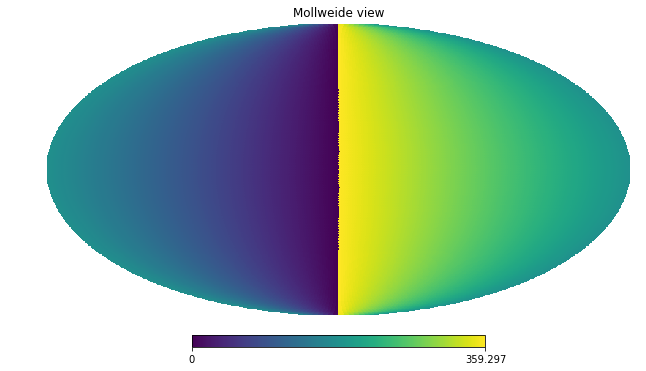

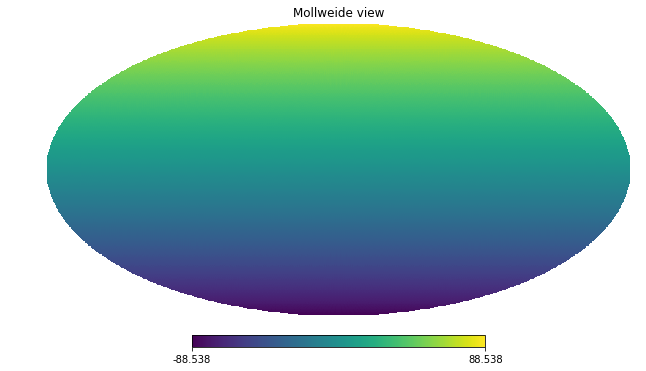

In [2]:
# Set up RA, dec maps
nside = 64
filtername = 'r'
ra, dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
hp.mollview(ra)
hp.mollview(dec)

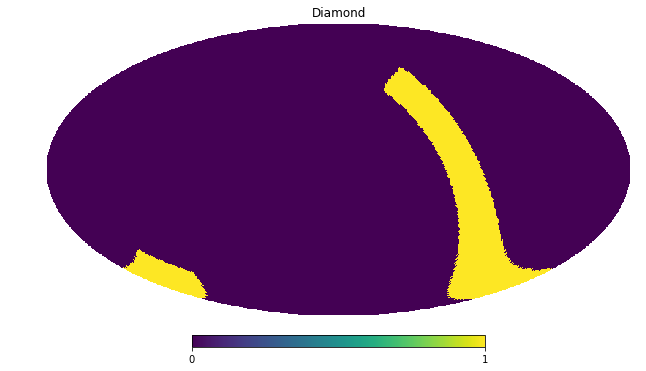

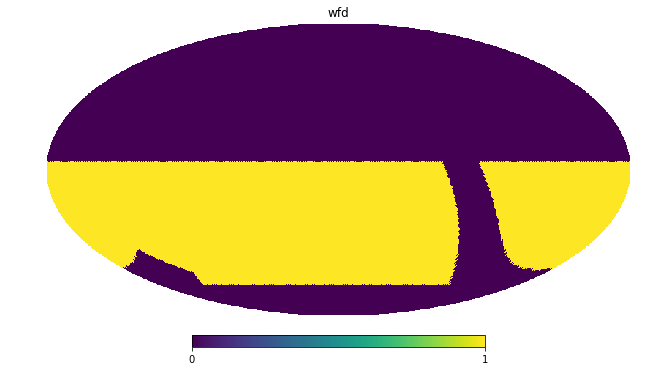

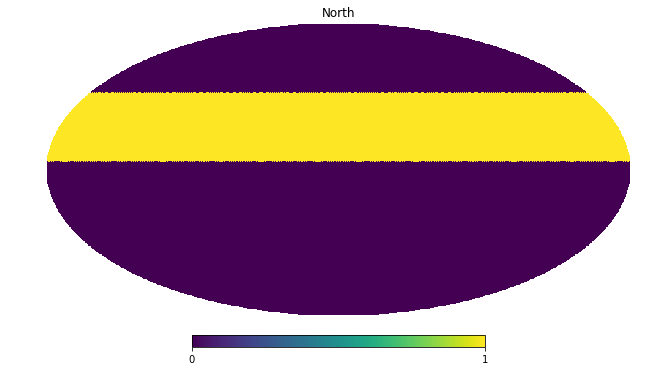

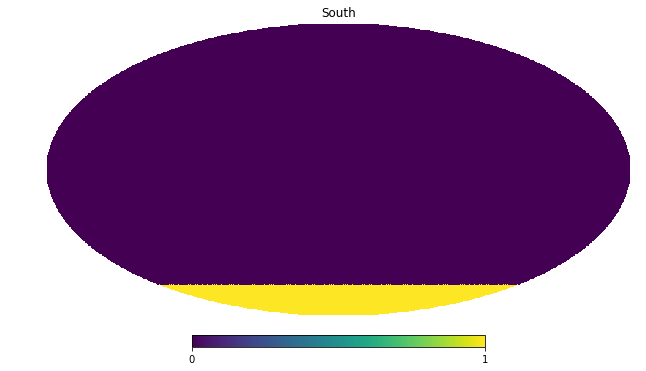

In [3]:
# Let's define some regions!
g_long, g_lat = galacticFromEquatorial(ra, dec)

diamond = np.where(((g_long < 90) | (g_long > 270)) & (np.abs(g_lat) < 10))
diamond_map = np.zeros(hp.nside2npix(nside), dtype=float)
diamond_map[diamond] = 1
wfd = np.where((dec > -62.5) & (dec < 3.6))
wfd_map = np.zeros(hp.nside2npix(nside), dtype=float)
wfd_map[wfd] = 1
wfd_map[diamond] = 0
hp.mollview(diamond_map, title='Diamond')
hp.mollview(wfd_map, title='wfd')

north = np.where((dec < 40) & (dec > -20))
north_map = np.zeros(hp.nside2npix(nside), dtype=float)
north_map[north] = 1
north_map[wfd] = 0
hp.mollview(north_map, title='North')

south = np.where(dec < -62)
south_map = np.zeros(hp.nside2npix(nside), dtype=float)
south_map[south] = 1
south_map[wfd] = 0
hp.mollview(south_map, title='South')

In [4]:
# Let's load up the galfast map
data = np.load('/Users/yoachim/git_repos/sims_maps/StarMaps/starDensity_%s_nside_64.npz' % filtername)
# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = data['starDensity'].copy()
# magnitude bins 
bins=data['bins'].copy()
# pixels where there were so many stars some were skipped
mask = data['overMaxMask'].copy
data.close()

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


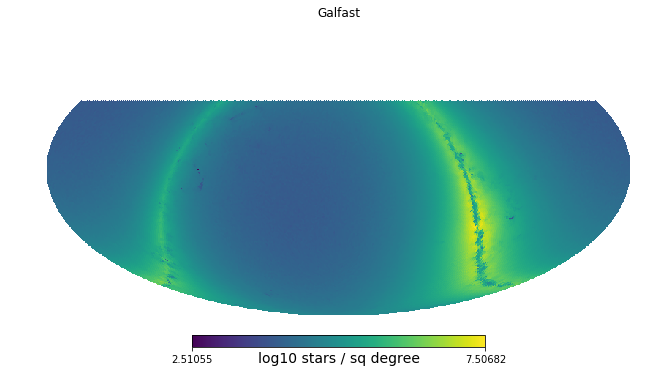

In [5]:
# Check the faintest map
hp.mollview(np.log10(starDensity[:,-1]), title='Galfast', unit='log10 stars / sq degree')

In [6]:
# Double check that we did indeed load up the correct resolution map
hp.npix2nside(starDensity[:,-1].size) == nside

True

In [7]:
bins

array([15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. ,
       17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2,
       19.4, 19.6, 19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4,
       21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6,
       23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8,
       26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. ])

In [8]:
# rather than interpolate, let's just show what we got
rmags = [27.6, 27.4,  27., 24.6, 24.4,  24.]
indxes = [np.where(np.round(bins[1:]*10) == np.round(rmag*10)) for rmag in rmags]


In [9]:
masks = {'diamond': diamond_map, 'wfd': wfd_map, 'north': north_map, 'south': south_map}
pix_area = hp.nside2pixarea(nside, degrees=True)

In [10]:
names = ['rmag']
names.extend(list(masks.keys()))
types = [float]*len(names)
result_array = np.zeros(len(rmags), dtype=list(zip(names,types)))

In [11]:
for i,indx in enumerate(indxes):
    for key in masks:
        result_array[i][key] = np.sum(masks[key]*starDensity[:,indx].ravel())*pix_area/1e9
    result_array[i]['rmag'] = bins[1:][indx]

In [12]:
result_array

array([(27.6, 6.46568106, 1.49042624, 1.00836391, 0.43249736),
       (27.4, 6.14019749, 1.44098958, 0.9677897 , 0.41619019),
       (27. , 5.51143196, 1.34033536, 0.88790482, 0.38372572),
       (24.6, 2.69215474, 0.76747262, 0.48281021, 0.21273288),
       (24.4, 2.52543306, 0.72813192, 0.45608397, 0.2012324 ),
       (24. , 2.21620106, 0.65489869, 0.40617273, 0.17969896)],
      dtype=[('rmag', '<f8'), ('diamond', '<f8'), ('wfd', '<f8'), ('north', '<f8'), ('south', '<f8')])

In [13]:
df = pd.DataFrame(result_array)
print('billions of stars')
df

billions of stars


,rmag,diamond,wfd,north,south
0,27.6,6.465681,1.490426,1.008364,0.432497
1,27.4,6.140197,1.440990,0.967790,0.416190
2,27.0,5.511432,1.340335,0.887905,0.383726
3,24.6,2.692155,0.767473,0.482810,0.212733
4,24.4,2.525433,0.728132,0.456084,0.201232
5,24.0,2.216201,0.654899,0.406173,0.179699
